<a href="https://colab.research.google.com/github/scythe-327/glide-text2im/blob/main/FRONTEND_of_stable_diffusion_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Use Stable Diffusion for Free

This notebook is a companion for the [Build a free Stable Diffusion app with a GPU backend](https://www.assemblyai.com/blog/build-a-free-stable-diffusion-app-with-a-gpu-backend/). We will leverage Colab's free GPUs to create a small app that we can use to generate images.

It will take **1-2 minutes for all of the setup to complete**. After that, you will be able to **generate images in about 10 seconds** using the web app.

Before you start, make sure that the runtime is using a GPU by going to `Runtime > Change runtime type > Hardware accelerator` and ensuring that the dropdown says `GPU`.

# Step 1: Install Dependencies

Run the below cell to install all of the dependencies we will need to use the app. While the dependencies are installing, you can move on to the next step.


In [19]:
!pip install diffusers==0.10.2 transformers scipy ftfy accelerate  # To run Stable Diffusion
# !pip install pyngrok==4.1.1  # To register our ngrok token
!pip install flask-localtunnel
!pip install flask  # So we can make flask app port thru ngrok

# Step 2: Make an ngrok account

ngrok is a tool that will allow us to get a public link for our application. When we run the Flask app in Colab, we are running it on one of Google's servers, so accessing it through `localhost` is not possible. Instead, we use ngrok, a reverse proxy, to create an internet-accessible way to access the app.

### a) Go to [ngrok.com](https://ngrok.com/)
### b) Click "Sign up for free" and create an account
### c) Verify your email
### d) Go to the [ngrok dashboard](https://dashboard.ngrok.com/get-started/your-authtoken) and copy your Authtoken

<center> 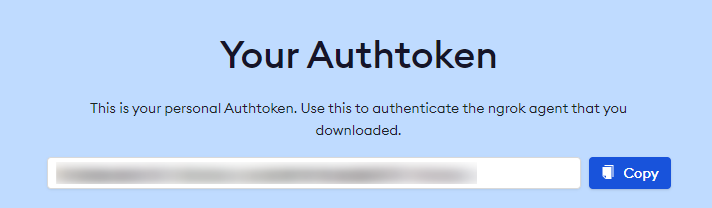</center>

### e) Paste your Authtoken below in place of `YOUR-AUTHTOKEN-HERE` and then **run the cell**

In [20]:
from flask import Flask
from flask_lt import run_with_lt

From here, the rest of the setup can be done fully automatically. If you do not want to learn about the rest of the setup, click `Runtime > Run after` (`Cntl + F10`) and then go down to **Step 5**.

# Step 3: Create the application files

Now we need to create the files we will need for the application. We start by making a folder `app` for the app.



In [21]:
import os
if not os.path.isdir('/content/app'):
  os.mkdir("/content/app")
os.chdir("/content/app")

Next we create a `static` subfolder and then create a CSS file `styles.css` inside it. This provides the final styling for our application.

In [22]:
if not os.path.isdir('/content/app/static'):
  os.mkdir("./static")
os.chdir("./static")

css = """
    body {
    font-family: Arial, Helvetica, sans-serif;
}

form {
    /* Center the form on the page */
    margin: 0 auto;
    width: 400px;
    /* Form outline */
    padding: 1em;
    display: flex;
}

img {
    border-radius: 8px;
    display: block;
    margin-left: auto;
    margin-right: auto;
    margin-top: 40px;
    filter: drop-shadow(5px 5px 10px #000);
    opacity: 1;
    hover: opacity: 0.6;
    transition: opacity 1s ease 0s;

}

ul,
li {
    display: inline
}

ul {
    list-style: none;
    padding: 0;
    margin: 0;
    display: flex
}

form li+li {
    margin-top: 1em;
}

label {
    /* Uniform size & alignment */
    display: inline-block;
    width: 90px;
    text-align: right;
}

input,
textarea {
    /* To make sure that all text fields have the same font settings
         By default, textareas have a monospace font */
    font: 1em sans-serif;

    /* Uniform text field size */
    width: 300px;
    box-sizing: border-box;

    /* Match form field borders */
    border: 1px solid #999;
}

input:focus,
textarea:focus {
    /* Additional highlight for focused elements */
    border-color: #000;
}

textarea {
    /* Align multiline text fields with their labels */
    vertical-align: top;

    /* Provide space to type some text */
    height: 5em;
}

.button {
    /* Align buttons with the text fields */
    padding-left: 90px;
    /* same size as the label elements */
}

button {
    /* This extra margin represent roughly the same space as the space
         between the labels and their text fields */
    margin-left: 0.5em;
}

label,
input {
    display: flex;
    flex-direction: column;
}

input,
label {
    display: block;
}"""

with open("styles.css", 'w') as f:
  f.write(css)

os.chdir("..")

Next we create and save `icon.png`, which stores our app's favicon.

In [23]:
import base64
s = b'iVBORw0KGgoAAAANSUhEUgAAABkAAAAZCAYAAADE6YVjAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAANrSURBVEhL3ZVLbE1BGMdn5lwuomk9bmlpUq82IqQSEQuiYUMIISJtUlytUo+FR4J2USJCSBOU0Gooi9K0Wo3HRiwECdqIsvCsPrS5dFNEvBbnjP83M+fqde9py9L/Zs73nTkz32+++eZm2H8jbqyn8oq+Ztq2U+w4zijbtgfBcsexme04PY5t364/M36fGeqpPiGByTtGJo+f9mJS+tzEuPgkBggDRFmAJflouxvKU0rMlJgSxnpIbgp1Pg3cvVUqm5tqGed6TWRdHyoy1lOekMCU7cOYlFlSOkwyh4U6mmXjvQv4ooJLehhQwvKN73LJ8ZInhEsxH1GmU1DOLTwE+9jT1f7zx5dS3fc7KzB3qRcPeUO42IxQBEDzSTTqLfH74/YgboceFdbUpRva0owfpZiQMemFaYxbC9CQgM80qxPgqkvHR/3AXu2nBHRtaIZaTqGaHEMxIVh9EFGH6SxUJui1zne/PvpJfZesAc/vxKDR1AdlLclrHWf8CEVBkqYeSEAGBb0ByOQTHuVmCLt8IvAZpoJwQKApjh/M9eT8qehMuMhH8AQTHO+w3KrrfnXogxmhhLCHXY8YfR2ACMi4GUcGI2C2yQLzfExQPbh1zgwJq7o0sRsDrukkNAg2fknu2yB5vRWZibTmo8AZGuKTlAXag9DzfQ/NiD8kqwigpUFSsgLTEVYEBMG3EIBOFRMA6VNVZj5Hqebk2FqY9ohTxtnsxcGWCfTmKgxJyTg1EYCF6tjqTMiGYK+bITGFoAeNB59IilZMD1dhCAKuw6qHK4CuA5qvouvZLnVs+1A9gjvGJyi11YvWtYw2XRqSOuscTpO11QTWjY6tsC6qUX2o9lQSLeKMu2Umm6Gcy/BxNpmINQCMVMeVaqFhNzufbGvX3/vVYRVbbVV42/ZSD0mkZlQKBA2qQvfKBLXBn21gqjudHMKEO242uixsxOLgmxxyhPAPycTqZ+rgBiR8j7lt3VNDB65KNxv10y9rVc+kOTVXcF+spAPOcG/QTSGZzG9rzIn6A/anFQVdrbgpU+l6dhxExc2JaBMFtmWe2R69TcJ6j2zq9LS/1lFt9H6ZzFYJbI3frYUBnW19lN3fsfWQrMY2fdO1IYKifEfR+TJA7qMuTQDsBOgYffkXXS1LocXNJReMl4h9gzFW9Qt/ieYwvJpjQQAAAABJRU5ErkJggg=='
with open('/content/app/static/icon.png', 'wb') as f:
  f.write(base64.decodebytes(s))

Next we create the `index.html` Jinja template that will be populated and returned by our Flask app as an HTML file.

In [24]:
html = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <link rel="stylesheet" type="text/css" href="{{ url_for('static',filename='styles.css') }}" />
    <link rel="icon" type="image/x-icon" href="{{ url_for('static',filename='icon.png') }}" />
    <title>Stable Diffusion App</title>
</head>
<body>
  <h1>Stable Diffusion App</h1>
    <p>Generate images with stable diffusion for free! Enter your prompt below and hit "Create" to generate an image (takes ~10 seconds per image).</p>
    <p>Companion article: <a href="https://www.assemblyai.com/blog/build-a-free-stable-diffusion-app-with-a-gpu-backend/">Build a free Stable Diffusion app with a GPU backend</a> on the <href="https://www.assemblyai.com/blog/">AssemblyAI Blog</a>.</p>
    <form action="\submit-prompt" method="post" id="submission-form">
        <ul>
            <li>
              <label for="prompt">Prompt:</label>
              <input type="text" id="prompt" name="prompt-input" />
            </li>
            <li class="button">
                <button type="submit">Create</button>
            </li>
          </ul>
    </form>
    <img src="{{ generated_image|default("https://images.squarespace-cdn.com/content/v1/6213c340453c3f502425776e/0715034d-4044-4c55-9131-e4bfd6dd20ca/2_4x.png?format=512w", true) }}" class="mainImg" alt="Generated Image">
</body>
</html>

"""

with open("index.html", 'w') as f:
  f.write(html)


# Step 4: Create and run the Flask app

The below code is a Flask application that serves as an API for our app. We run it to generate a publicly-accessible URL for our app.

The code is commented for details

In [30]:
import os
import urllib
os.chdir("/content/app")
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

Password/Enpoint IP for localtunnel is: 34.31.0.67


In [ ]:
# from flask_ngrok import run_with_ngrok
from flask import Flask, render_template, send_file, request

import torch
from diffusers import StableDiffusionPipeline

import base64
from io import BytesIO

# Load model
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", revision="fp16", torch_dtype=torch.float16)
pipe.to("cuda")

# Start flask app and set to ngrok
app = Flask(__name__, template_folder='.') # period is because default templates folder is /templates
run_with_lt(app)

@app.route('/')
def initial():
  return render_template('index.html')

@app.route('/submit-prompt', methods=['POST'])
def generate_image():
  prompt = request.form['prompt-input']
  print(f"Generating an image of {prompt}")

  image = pipe(prompt).images[0]
  print("Image generated! Converting image ...")

  buffered = BytesIO()
  image.save(buffered, format="PNG")
  img_str = base64.b64encode(buffered.getvalue())
  b = "data:image/png;base64," + str(img_str)[2:-1]

  print("Sending image ...")
  return render_template('index.html', generated_image=b)

if __name__ == '__main__':
    app.run()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 your url is: https://soft-flowers-flash.loca.lt


INFO:werkzeug:127.0.0.1 - - [23/Jul/2023 04:34:22] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Jul/2023 04:34:23] "GET /static/styles.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Jul/2023 04:34:23] "GET /static/icon.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Jul/2023 04:34:23] "GET /static/icon.png HTTP/1.1" 304 -


Generating an image of blue rose


  0%|          | 0/50 [00:00<?, ?it/s]

INFO:werkzeug:127.0.0.1 - - [23/Jul/2023 04:34:55] "POST /submit-prompt HTTP/1.1" 200 -


Image generated! Converting image ...
Sending image ...


INFO:werkzeug:127.0.0.1 - - [23/Jul/2023 04:34:56] "GET /static/styles.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [23/Jul/2023 04:35:05] "GET /static/icon.png HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [23/Jul/2023 04:35:05] "GET /static/icon.png HTTP/1.1" 304 -


# Step 5: Use the application

Wait until the above cell has finished running. If an error like `HTTPConnectionPool: Max retries exceeded with url ...` is displayed, then go back to step 2e and make sure you entered your ngrok Authtoken properly.

To access the app, click the second-to-last link output in the cell above, which will have a form like `http://<SOME-CHARACTERS>.ngrok.io`. You will see a page like this:

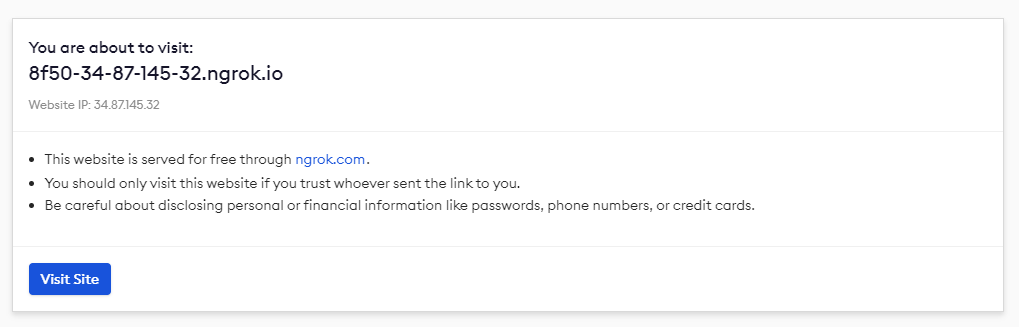

Click "Visit Site", and then you will see the app:

<center>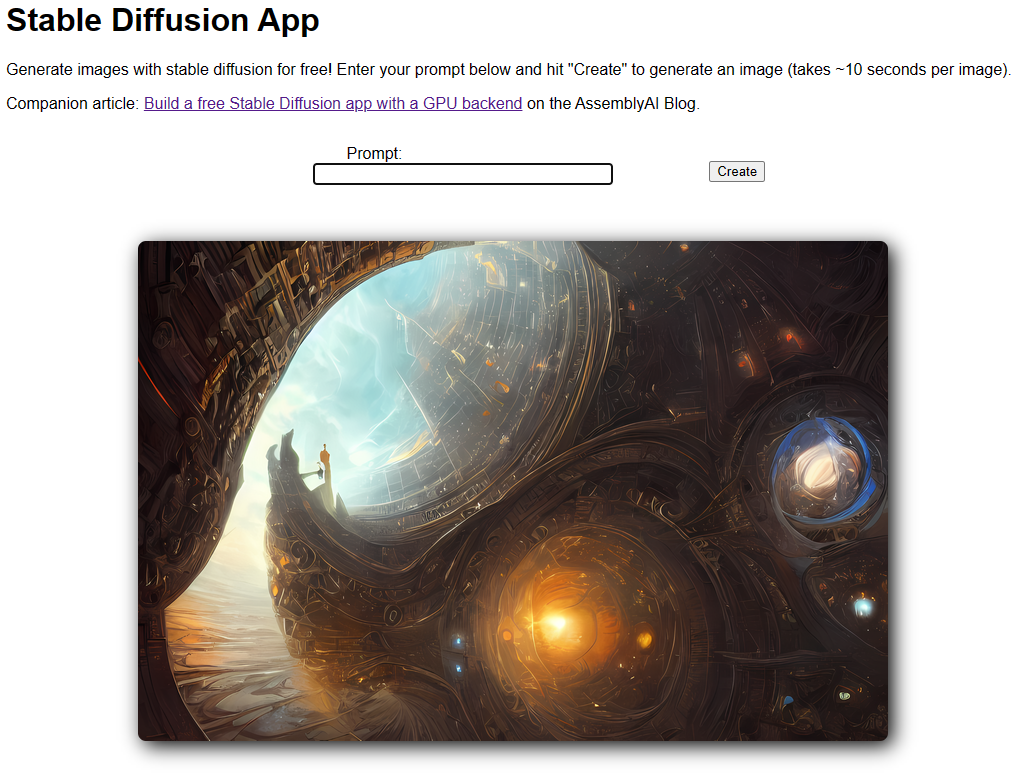</img></center>

Simply enter a prompt and click "Create" in order to generate an image, which will take about **10 seconds**. You can keep an eye on progress in the output of the above cell:

<center>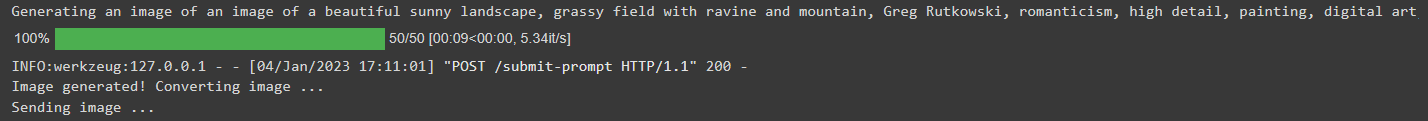</img></center>

Once the image has been generated, it will be automatically displayed in the app:

<center>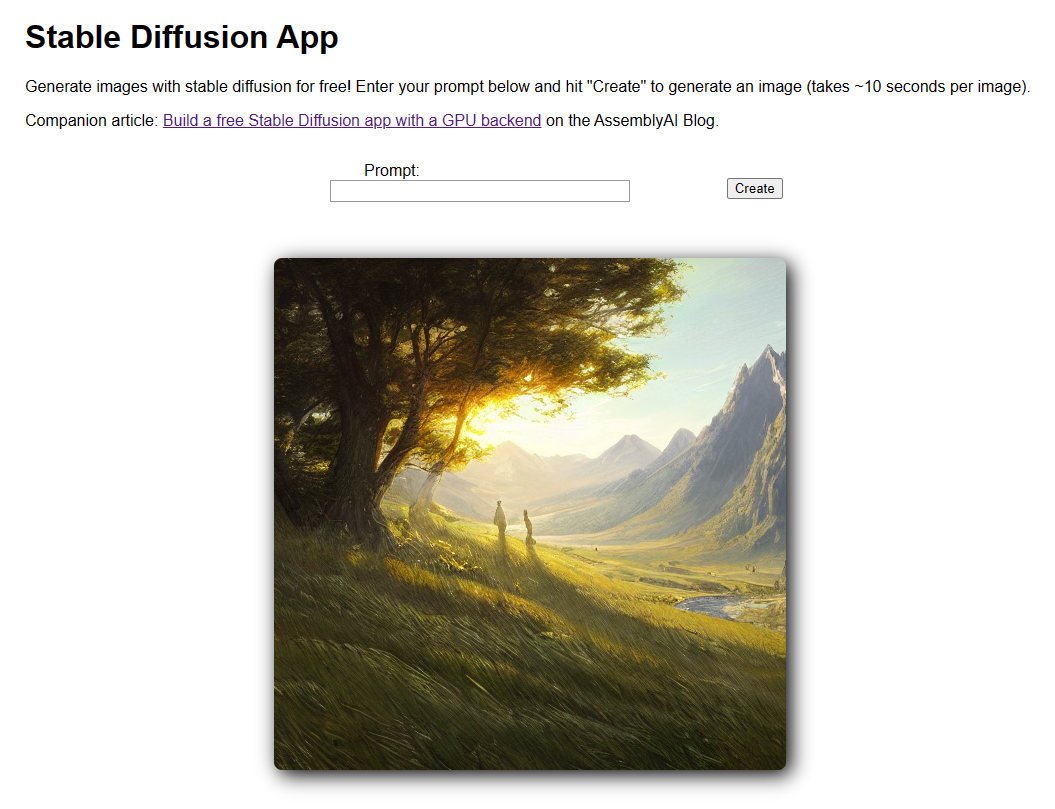</img></center>

Right click on an image to save it

# Final Words

That's all it takes to build a simple, free-to-use web app for Stable Diffusion! If you have more questions about text-to-image models, check out some of the below resources for further learning:

1. [How do I build a text-to-image model?](https://www.assemblyai.com/blog/minimagen-build-your-own-imagen-text-to-image-model/)
2. [How does DALL-E 2 work?](https://www.assemblyai.com/blog/how-dall-e-2-actually-works/)
3. [How does Imagen work?](https://www.assemblyai.com/blog/how-imagen-actually-works/)
4. [What is classifier-free guidance?](https://www.assemblyai.com/blog/how-imagen-actually-works/#classifier-free-guidance)
5. [What is prompt engineering?](https://www.assemblyai.com/blog/how-to-run-stable-diffusion-locally-to-generate-images/#prompt-engineering)

Alternatively, consider following our [YouTube](https://www.youtube.com/c/AssemblyAI) channel, [Twitter](https://twitter.com/AssemblyAI), or [newsletter](https://subscribe.assemblyai.com/) to stay up to date with our latest tutorials and deep dives!